In [96]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

import yfinance as yf

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
def get_prices(ticker: str, start_date: str, end_date: str = None, interval: str = '1d') -> pd.DataFrame:
    """ 
    Get historical prices for a given ticker.

    Parameters:
        - ticker (str): The ticker symbol of the stock.
        - start (str): The start date of the historical prices.
        - end_str (str): (default=None) The end date of the historical prices.
        - interval (str): (default='1d') The interval of the historical prices.
    """

    price_df_list = []

    if end_date is None:
        end_date = pd.Timestamp.now().strftime('%Y-%m-%d')

    start_year = int(start_date.split('-')[0])
    end_year = int(end_date.split('-')[0])

    # get prices for each year and concat to get the full price_df
    for year in range(start_year, end_year + 1):
        if year == start_year:
            price_df = yf.Ticker(ticker).history(
                interval=interval, start=start_date, end=f'{year}-12-31')
        elif year == end_year:
            price_df = yf.Ticker(ticker).history(
                interval=interval, start=f'{year}-01-01', end=end_date)
        else:
            price_df = yf.Ticker(ticker).history(
                interval=interval, start=f'{year}-01-01', end=f'{year}-12-31')

        price_df_list.append(price_df)

    price_df = pd.concat(price_df_list)

    return price_df

In [62]:
def get_return(price_df: pd.DataFrame, interval: str = 'M') -> pd.DataFrame:
    """ 
    Get return of stock on a monthly basis (last close price/last close price previous period - 1)

        - pride_df: pd.DataFrame
        - interval: str (default='M')
    """
    assert interval in ['M', 'Q', 'Y'], 'interval must be M, Q or Y'

    # find the last close price of each period
    last_close_price = price_df.resample(interval).last()

    # calculate the return
    return_series = last_close_price['Close'].pct_change()*100

    # turn into a dataframe
    return_series = return_series.to_frame()

    return_series.columns = [f'{interval}_Return (%)']
    # set index to month
    return_series.index = return_series.index.strftime('%Y-%m')

    return return_series

In [63]:
my_portfolio_tickers = ['AGL', 'CSL', 'IEL', 'NVX', 'TWE', 'TYR', 'SPY']

historical_prices = {}

for ticker in my_portfolio_tickers:
    historical_prices[ticker] = get_prices(f'{ticker}.AX', '2013-12-01')

$IEL.AX: possibly delisted; no price data found  (1d 2013-12-01 -> 2013-12-31) (Yahoo error = "Data doesn't exist for startDate = 1385816400, endDate = 1388408400")
$IEL.AX: possibly delisted; no price data found  (1d 2014-01-01 -> 2014-12-31) (Yahoo error = "Data doesn't exist for startDate = 1388494800, endDate = 1419944400")
$NVX.AX: possibly delisted; no price data found  (1d 2013-12-01 -> 2013-12-31) (Yahoo error = "Data doesn't exist for startDate = 1385816400, endDate = 1388408400")
$NVX.AX: possibly delisted; no price data found  (1d 2014-01-01 -> 2014-12-31) (Yahoo error = "Data doesn't exist for startDate = 1388494800, endDate = 1419944400")
$TYR.AX: possibly delisted; no price data found  (1d 2013-12-01 -> 2013-12-31) (Yahoo error = "Data doesn't exist for startDate = 1385816400, endDate = 1388408400")
$TYR.AX: possibly delisted; no price data found  (1d 2014-01-01 -> 2014-12-31) (Yahoo error = "Data doesn't exist for startDate = 1388494800, endDate = 1419944400")
$TYR.AX: p

In [6]:
def get_stats(monthly_returns_df_dict: str, ticker: str, start_period: str, end_year: str):

    period_of_interest_return_df = monthly_returns_df_dict[ticker].loc[start_period:end_year]

    stats_dict = {}

    # mean, std, n
    stats_dict['mean'] = np.round(
        period_of_interest_return_df.mean().values[0], 4)
    stats_dict['std'] = np.round(
        period_of_interest_return_df.std().values[0], 4)
    stats_dict['n'] = period_of_interest_return_df.shape[0]

    # sharpe
    mode = monthly_returns_df_dict[ticker].columns[0].split('_')[0]
    sharpe_multiplier = 4 if mode == 'Q' else 12 if mode == 'M' else 1
    stats_dict['sharpe'] = np.round(np.sqrt(
        sharpe_multiplier) * stats_dict['mean'] / stats_dict['std'], 2)

    # beta
    X = monthly_returns_df_dict['SPY'].loc[start_period:end_year][f'{mode}_Return']
    X = sm.add_constant(X)
    y = monthly_returns_df_dict[ticker].loc[start_period:end_year][f'{mode}_Return']
    linreg = sm.OLS(y, X).fit()
    stats_dict['beta'] = np.round(linreg.params[f'{mode}_Return'], 2)
    stats_dict['alpha'] = np.round(linreg.params['const'], 2)
    

    return stats_dict

In [74]:
monthly_returns_df_dict = {}
for ticker, price_df in historical_prices.items():
    monthly_returns_df_dict[ticker] = get_return(price_df)

quarterly_returns_df_dict = {}
for ticker, price_df in historical_prices.items():
    quarterly_returns_df_dict[ticker] = get_return(price_df, 'Q')

yearly_returns_df_dict = {}
for ticker, price_df in historical_prices.items():
    yearly_returns_df_dict[ticker] = get_return(price_df, 'Y')

In [10]:
for ticker in my_portfolio_tickers:
    print(ticker, ':', get_stats(
        monthly_returns_df_dict, ticker, '2021-06', '2024-06'))

AGL : {'mean': 0.0156, 'std': 0.0898, 'n': 37, 'sharpe': 0.6, 'beta': -0.44, 'alpha': 0.02}
CSL : {'mean': 0.0028, 'std': 0.053, 'n': 37, 'sharpe': 0.18, 'beta': 0.57, 'alpha': -0.0}
IEL : {'mean': -0.0043, 'std': 0.1049, 'n': 37, 'sharpe': -0.14, 'beta': 1.0, 'alpha': -0.02}
NVX : {'mean': 0.003, 'std': 0.2805, 'n': 37, 'sharpe': 0.04, 'beta': 4.26, 'alpha': -0.05}
TWE : {'mean': 0.0065, 'std': 0.0682, 'n': 37, 'sharpe': 0.33, 'beta': 0.28, 'alpha': 0.0}
TYR : {'mean': -0.015, 'std': 0.2011, 'n': 37, 'sharpe': -0.26, 'beta': 2.27, 'alpha': -0.05}
SPY : {'mean': 0.0132, 'std': 0.0388, 'n': 37, 'sharpe': 1.18, 'beta': 1.0, 'alpha': 0.0}


In [11]:
def historical_corr(monthly_returns_df_dict: dict, start_period: str, end_year: str):
    """
    Get the historical correlation between two stocks.

    Parameters:
        - historical_returns: dict
        - start_period: str
        - end_year: str
    """

    period_of_interest_return_df = pd.DataFrame()

    for ticker, returns_df in monthly_returns_df_dict.items():
        returns_df = returns_df.loc[start_period:end_year]
        returns_df.rename(
            columns={returns_df.columns[0]: ticker}, inplace=True)

        period_of_interest_return_df = pd.merge(
            period_of_interest_return_df, returns_df, left_index=True, right_index=True, how='outer')

    # calculate correlation: corr() function from pandas
    correlation_df = period_of_interest_return_df.corr()  # TODO

    return correlation_df, period_of_interest_return_df

In [12]:
correlation_df, period_of_interest_return_df = historical_corr(
    monthly_returns_df_dict, '2015-01', '2023-12')
correlation_df

,AGL,CSL,IEL,NVX,TWE,TYR,SPY
AGL,1.000000,0.048722,-0.077654,-0.116394,0.028229,-0.165138,0.106511
CSL,0.048722,1.000000,0.251355,-0.018576,0.220370,0.317659,0.423119
IEL,-0.077654,0.251355,1.000000,0.268241,0.019208,0.508648,0.312200
NVX,-0.116394,-0.018576,0.268241,1.000000,0.235992,0.217099,0.219132
TWE,0.028229,0.220370,0.019208,0.235992,1.000000,0.163464,0.169761
TYR,-0.165138,0.317659,0.508648,0.217099,0.163464,1.000000,0.494307
SPY,0.106511,0.423119,0.312200,0.219132,0.169761,0.494307,1.000000


In [72]:
historical_prices['NVX'].tail(60)

,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
Date,,,,,,,,
2024-06-21 00:00:00+10:00,0.650,0.6500,0.6300,0.630,NaN,749780.0,0.0,0.0
2024-06-24 00:00:00+10:00,0.655,0.6950,0.6550,0.685,NaN,3108016.0,0.0,0.0
2024-06-25 00:00:00+10:00,0.725,0.7600,0.7250,0.745,NaN,4222090.0,0.0,0.0
2024-06-26 00:00:00+10:00,0.785,0.8000,0.7650,0.790,NaN,3376787.0,0.0,0.0
2024-06-27 00:00:00+10:00,0.770,0.7700,0.7450,0.765,NaN,1387811.0,0.0,0.0
2024-06-28 00:00:00+10:00,0.750,0.7500,0.7000,0.710,NaN,2521459.0,0.0,0.0
2024-07-01 00:00:00+10:00,0.700,0.7350,0.6950,0.730,NaN,1124031.0,0.0,0.0
2024-07-02 00:00:00+10:00,0.720,0.7250,0.7050,0.705,NaN,534958.0,0.0,0.0
2024-07-03 00:00:00+10:00,0.705,0.7250,0.7000,0.705,NaN,520150.0,0.0,0.0


In [65]:
monthly_returns_df_dict['NVX'].tail(60)

,M_Return (%)
Date,
2019-10,19.192189
2019-11,-15.254308
2019-12,0.999868
2020-01,-11.880995
2020-02,-25.842973
2020-03,-22.727253
2020-04,37.254941
2020-05,72.692365
2020-06,100.000000


In [75]:
yearly_returns_df_dict['NVX'].tail(60)

,Y_Return (%)
Date,
2015-12,NaN
2016-12,67.741797
2017-12,73.077046
2018-12,-45.555613
2019-12,3.061099
2020-12,219.167077
2021-12,700.862089
2022-12,-84.176534
2023-12,-50.000000


In [76]:
quarterly_returns_df_dict['NVX'].tail(60)

,Q_Return (%)
Date,
2015-12,NaN
2016-03,25.806127
2016-06,-10.256483
2016-09,94.286054
2016-12,-23.529349
2017-03,55.769256
2017-06,-7.407448
2017-09,26.666634
2017-12,-5.263040


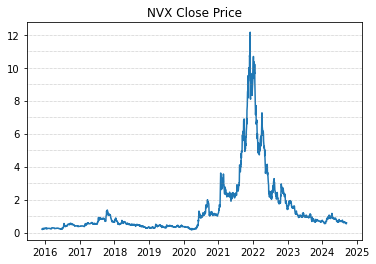

In [55]:
# TODO: recent plot - different intervals
ticker = 'NVX'

plt.title(f'{ticker} Close Price')
plt.plot(historical_prices[ticker]['Close'])
# plot some horizontal lines at each dollar (dotted faint line)
for i in range(int(np.ceil(historical_prices[ticker]['Close'].min())-1), int(np.floor(historical_prices[ticker]['Close'].max()))+1):
    plt.axhline(y=i, color='gray', linestyle=':', linewidth=0.5)
plt.show()

In [56]:
# dividends
display(historical_prices[ticker][historical_prices[ticker]
                                  ['Dividends'] != 0][['Dividends']])

,Dividends
Date,


In [57]:
# stock splits
display(historical_prices[ticker][historical_prices[ticker]
                                  ['Stock Splits'] != 0][['Stock Splits']])

,Stock Splits
Date,


# Other Stats

In [99]:
object = yf.Ticker('NVX.AX')

In [100]:
object.info

{'address1': '46 Edward Street',
 'address2': 'Level 8',
 'city': 'Brisbane',
 'state': 'QLD',
 'zip': '4000',
 'country': 'Australia',
 'phone': '61 4 3931 0818',
 'website': 'https://www.novonixgroup.com',
 'industry': 'Electrical Equipment & Parts',
 'industryKey': 'electrical-equipment-parts',
 'industryDisp': 'Electrical Equipment & Parts',
 'sector': 'Industrials',
 'sectorKey': 'industrials',
 'sectorDisp': 'Industrials',
 'longBusinessSummary': 'NOVONIX Limited provides battery materials and development technology for battery manufacturers, materials companies, automotive original equipment manufacturers (OEMs), and consumer electronics manufacturers in North America, Asia, Australia, and Europe. It operates through Battery Materials and Battery Technology segments. The Battery Materials segment develops and manufactures battery anode materials. The Battery Technology segment develops battery cell testing equipment, performs consulting services, and carries out research and dev

In [101]:
# - income statement
object.income_stmt

,2023-12-31,2022-06-30,2021-06-30,2020-06-30
Tax Effect Of Unusual Items,12420.032031,0.0,0.0,0.0
Tax Rate For Calcs,0.004305,0.0,0.0,0.0
Normalized EBITDA,-41747703.0,-43259259.0,-9976377.0,-9637124.0
Total Unusual Items,2885177.0,-2917859.0,-2064926.0,-252207.0
Total Unusual Items Excluding Goodwill,2885177.0,-2917859.0,-2064926.0,-252207.0
Net Income From Continuing Operation Net Minority Interest,-46248261.0,-51860307.0,-13446593.0,-13430174.0
Reconciled Depreciation,4739719.0,4214620.0,1264622.0,1183292.0
Reconciled Cost Of Revenue,2817685.0,1724622.0,810664.0,576538.0
EBITDA,-38862526.0,-46177118.0,-12041303.0,-9889331.0
EBIT,-43602661.0,-50391738.0,-13305925.0,-11072623.0


In [102]:
object.quarterly_income_stmt

""


In [113]:
object.get_eps_trend()

,current,7daysAgo,30daysAgo,60daysAgo,90daysAgo
0q,0.00,-0.11,-0.11,-0.11,-0.11
+1q,0.00,0.00,0.00,0.00,0.00
0y,-0.20,-0.20,-0.20,-0.20,-0.11
+1y,-0.24,-0.24,-0.24,-0.24,-0.22


In [123]:
dir(object)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_analysis',
 '_data',
 '_download_options',
 '_earnings',
 '_earnings_dates',
 '_expirations',
 '_fast_info',
 '_fetch_ticker_tz',
 '_financials',
 '_fundamentals',
 '_get_ticker_tz',
 '_holders',
 '_isin',
 '_lazy_load_price_history',
 '_news',
 '_options2df',
 '_price_history',
 '_quote',
 '_shares',
 '_tz',
 '_underlying',
 'actions',
 'analyst_price_targets',
 'balance_sheet',
 'balancesheet',
 'basic_info',
 'calendar',
 'capital_gains',
 'cash_flow',
 'cashflow',
 'dividends',
 'earnings',
 'earnings_dates',
 'earnings_estimate',
 'earnings_history',
 'eps_revisions',
 'eps_trend',
 'fast_info',
 'financials',
 'ge

In [103]:
# - balance sheet
object.balance_sheet

,2023-12-31,2022-12-31,2022-06-30,2021-06-30,2020-06-30
Ordinary Shares Number,488733461.0,486774622.0,485951369.0,404601384.0,NaN
Share Issued,488733461.0,486774622.0,485951369.0,404601384.0,NaN
Total Debt,69387750.0,41341840.0,42309006.0,10356322.0,NaN
Tangible Book Value,171945966.0,213882559.0,238768701.0,126001019.0,NaN
Invested Capital,247331164.0,261248012.0,287200725.0,143068845.0,NaN
...,...,...,...,...,...
Accounts Receivable,3034897.0,2327364.0,2081315.0,1151116.0,NaN
Gross Accounts Receivable,NaN,NaN,NaN,1533963.0,952881.0
Cash Cash Equivalents And Short Term Investments,78713885.0,99039172.0,142737362.0,102601252.0,NaN
Cash And Cash Equivalents,78713885.0,99039172.0,142737362.0,102601252.0,NaN


In [104]:
object.quarterly_balance_sheet

,2023-12-31,2023-06-30
Ordinary Shares Number,488733461.0,486947711.0
Share Issued,488733461.0,486947711.0
Total Debt,69387750.0,69215882.0
Tangible Book Value,171945966.0,189874083.0
Invested Capital,247331164.0,265082883.0
...,...,...
Receivables,3564333.0,2325063.0
Other Receivables,529436.0,NaN
Accounts Receivable,3034897.0,2325063.0
Cash Cash Equivalents And Short Term Investments,78713885.0,99075082.0


In [105]:
# - cash flow statement
object.cashflow

,2023-12-31,2022-06-30,2021-06-30,2020-06-30
Free Cash Flow,-55424219.0,-113019442.0,-25664712.0,-7426208.0
Repurchase Of Capital Stock,NaN,NaN,-7908866.0,-1308596.0
Repayment Of Debt,-1426460.0,-881850.0,-206308.0,-4784765.0
Issuance Of Debt,30752831.0,33241890.0,3023995.0,4426384.0
Issuance Of Capital Stock,338327.0,150967705.0,106843050.0,31664061.0
...,...,...,...,...
Paymentsto Suppliersfor Goodsand Services,NaN,NaN,-10935814.750255,-6698474.59374
Classesof Cash Receiptsfrom Operating Activities,NaN,NaN,4940637.584901,3014011.062631
Other Cash Receiptsfrom Operating Activities,NaN,NaN,NaN,-1.0
Receiptsfrom Government Grants,NaN,NaN,639569.934483,NaN


In [106]:
object.quarterly_cashflow

,2024-03-31,2023-12-31,2023-09-30,2023-06-30,2023-03-31
Free Cash Flow,-14739000.0,-8065219.0,-13017000.0,-14766453.0,-19581000.0
Repayment Of Debt,-333000.0,-640460.0,-268000.0,-310259.0,-426000.0
Issuance Of Debt,0.0,-1169.0,0.0,29834768.0,919000.0
Issuance Of Capital Stock,0.0,338327.0,0.0,0.0,0.0
Capital Expenditure,-1569000.0,-1928796.0,-4067000.0,-6253429.0,-6952000.0
End Cash Position,62244000.0,78713885.0,86752000.0,99075082.0,78707000.0
Beginning Cash Position,78713000.0,86752000.0,99075000.0,78707000.0,99039000.0
Effect Of Exchange Rate Changes,-912000.0,801362.0,-18000.0,-1781909.0,-672000.0
Changes In Cash,-15557000.0,-8839649.0,-12305000.0,22149819.0,-19660000.0
Financing Cash Flow,-482000.0,-447212.0,-259000.0,29568346.0,447000.0


In [107]:
# Show future and historic earnings dates, returns at most next 4 quarters and last 8 quarters by default.
# Note: If more are needed use object.get_earnings_dates(limit=XX) with increased limit argument.
object.earnings_dates

,EPS Estimate,Reported EPS,Surprise(%)
Earnings Date,,,
2025-08-20 20:00:00+10:00,NaN,NaN,NaN
2025-02-28 21:00:00+11:00,-0.11,NaN,NaN
2024-08-22 20:00:00+10:00,-0.11,NaN,NaN
2024-08-22 09:00:00+10:00,NaN,NaN,NaN
2024-07-15 08:00:00+10:00,NaN,NaN,NaN
2024-02-28 23:00:00+11:00,NaN,NaN,NaN
2022-08-31 12:00:00+10:00,NaN,NaN,NaN
2022-02-25 10:00:00+11:00,NaN,NaN,NaN
2021-08-26 15:00:00+10:00,NaN,NaN,NaN
